In [61]:
import torch
import torch.nn as nn
from sklearn.datasets import fetch_openml
import tensorflow as tf
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split


In [62]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [63]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [64]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


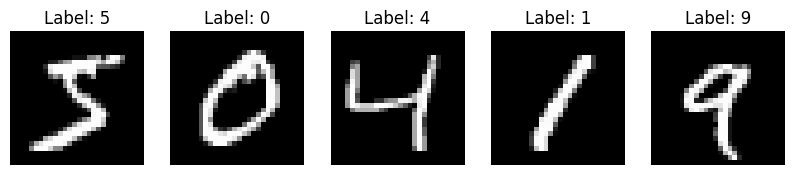

In [65]:

# Function to plot samples
def plot_samples(x, y, num_samples=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x[i], cmap='gray')
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.show()

# Plot the first 5 samples from the training set
plot_samples(x_train, y_train)

In [66]:
# CONVERSION OF NUMPY ARRAYS TO TENSORS IN PYTORCH
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [67]:
# ADDING A CHANNEL DIMENSION TO TENSORS
# THIS IS BEACUSE The MNIST IMAGES ARE GRAY SCALE OF SHAPE (28, 28). 
# PyTorch models typically expect an additional channel dimension (1, 28, 28)

x_train_tensor = x_train_tensor.unsqueeze(1)
x_test_tensor = x_test_tensor.unsqueeze(1)

In [68]:
print(type(x_train_tensor), x_train_tensor.shape)
print(type(y_train_tensor), y_train_tensor.shape)
print(type(x_test_tensor), x_test_tensor.shape)
print(type(y_test_tensor), y_test_tensor.shape)

<class 'torch.Tensor'> torch.Size([60000, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([60000])
<class 'torch.Tensor'> torch.Size([10000, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([10000])


In [69]:
# Create a full training dataset
full_train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

# Define the size of training and validation sets
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Split the full training dataset into training and validation sets
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])


In [70]:
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), batch_size=1000, shuffle=False)

In [71]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [34]:
import torch.optim as optim

# Initialize the model, loss function, and optimizer
model0 = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model0.parameters(), lr=0.001)

# Training loop
num_epochs = 8
for epoch in range(num_epochs):
    model0.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model0(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Validation step
    model0.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model0(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")


Epoch [1/8], Loss: 0.1983
Validation Loss: 0.0640, Accuracy: 98.06%
Epoch [2/8], Loss: 0.0536
Validation Loss: 0.0566, Accuracy: 98.34%
Epoch [3/8], Loss: 0.0387
Validation Loss: 0.0404, Accuracy: 98.81%
Epoch [4/8], Loss: 0.0297
Validation Loss: 0.0378, Accuracy: 98.92%
Epoch [5/8], Loss: 0.0234
Validation Loss: 0.0388, Accuracy: 98.85%
Epoch [6/8], Loss: 0.0172
Validation Loss: 0.0406, Accuracy: 98.74%
Epoch [7/8], Loss: 0.0138
Validation Loss: 0.0404, Accuracy: 98.89%
Epoch [8/8], Loss: 0.0115
Validation Loss: 0.0327, Accuracy: 99.08%


In [74]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def evaluate_cuda(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


In [76]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            # images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


Accuracy: 99.07%
Precision: 0.9907, Recall: 0.9906, F1-score: 0.9906


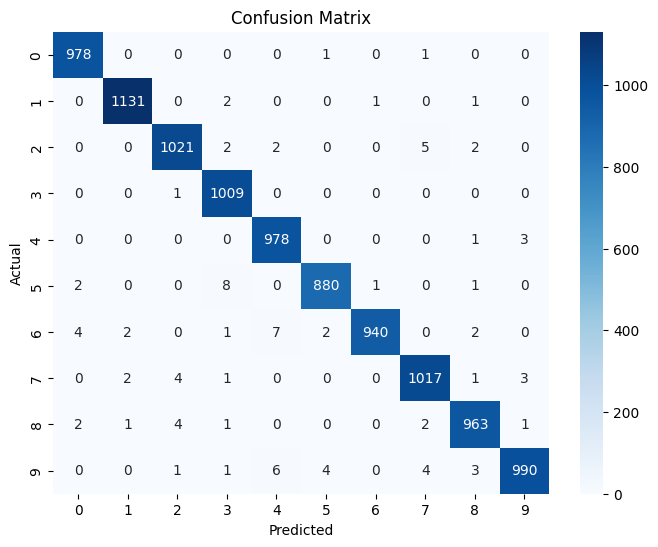

In [78]:
evaluate(model0, test_loader)

INCREASING COMPLEXITY

Adding batch normalization layers

increasing number of epochs

Altering learining rate


In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model1 = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model1.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) 
        optimizer.zero_grad()
        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Validation step
    model1.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device) 
            outputs = model1(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Epoch [1/10], Loss: 0.2646
Validation Loss: 0.0477, Accuracy: 98.63%
Epoch [2/10], Loss: 0.0851
Validation Loss: 0.0376, Accuracy: 98.86%
Epoch [3/10], Loss: 0.0615
Validation Loss: 0.0484, Accuracy: 98.65%
Epoch [4/10], Loss: 0.0513
Validation Loss: 0.0330, Accuracy: 99.12%
Epoch [5/10], Loss: 0.0446
Validation Loss: 0.0383, Accuracy: 98.96%
Epoch [6/10], Loss: 0.0401
Validation Loss: 0.0323, Accuracy: 99.21%
Epoch [7/10], Loss: 0.0337
Validation Loss: 0.0345, Accuracy: 99.14%
Epoch [8/10], Loss: 0.0303
Validation Loss: 0.0415, Accuracy: 99.18%
Epoch [9/10], Loss: 0.0261
Validation Loss: 0.0432, Accuracy: 98.84%
Epoch [10/10], Loss: 0.0239
Validation Loss: 0.0498, Accuracy: 98.88%


Accuracy: 98.98%
Precision: 0.9900, Recall: 0.9896, F1-score: 0.9898


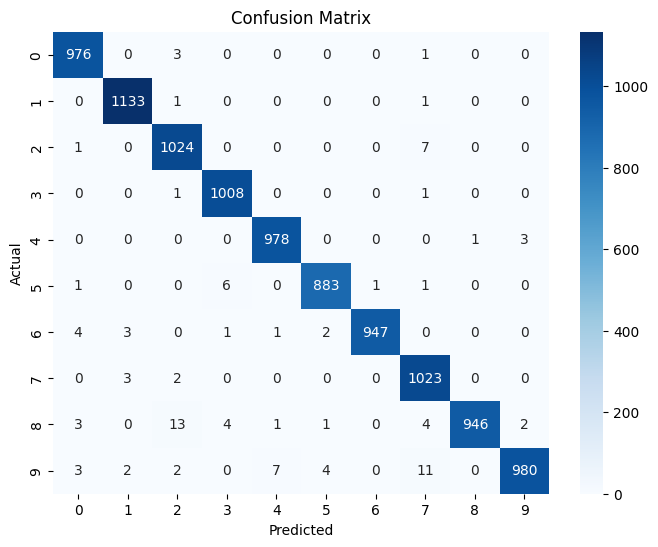

In [79]:
evaluate_cuda(model1, test_loader)

Activation function Sogmoid

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.pool(torch.sigmoid(self.bn1(self.conv1(x))))
        x = self.pool(torch.sigmoid(self.bn2(self.conv2(x))))
        x = self.pool(torch.sigmoid(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model2 = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Validation step
    model2.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model2(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Epoch [1/10], Loss: 0.9011
Validation Loss: 0.2509, Accuracy: 92.97%
Epoch [2/10], Loss: 0.1696
Validation Loss: 0.0950, Accuracy: 97.16%
Epoch [3/10], Loss: 0.1104
Validation Loss: 0.0911, Accuracy: 97.28%
Epoch [4/10], Loss: 0.0841
Validation Loss: 0.0881, Accuracy: 97.31%
Epoch [5/10], Loss: 0.0735
Validation Loss: 0.0576, Accuracy: 98.29%
Epoch [6/10], Loss: 0.0629
Validation Loss: 0.0957, Accuracy: 97.09%
Epoch [7/10], Loss: 0.0544
Validation Loss: 0.2418, Accuracy: 92.35%
Epoch [8/10], Loss: 0.0463
Validation Loss: 0.1254, Accuracy: 96.13%
Epoch [9/10], Loss: 0.0444
Validation Loss: 0.0443, Accuracy: 98.72%
Epoch [10/10], Loss: 0.0391
Validation Loss: 0.0373, Accuracy: 98.85%


Accuracy: 98.95%
Precision: 0.9896, Recall: 0.9894, F1-score: 0.9894


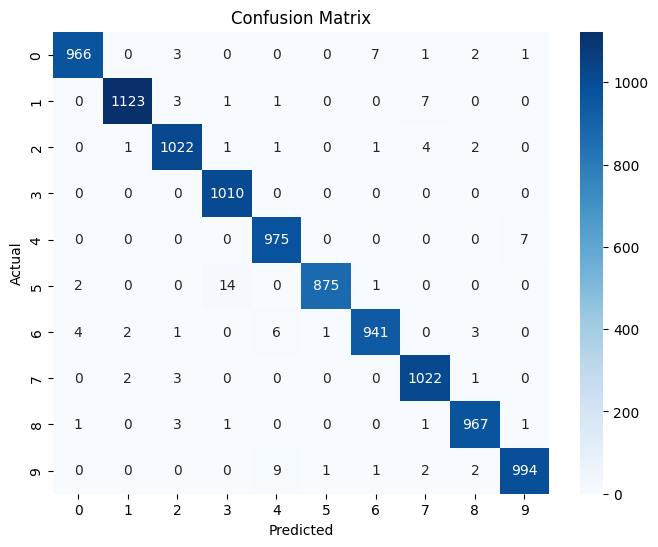

In [80]:
evaluate_cuda(model2, test_loader)

Using Activation function Tanh

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.pool(torch.tanh(self.bn1(self.conv1(x))))
        x = self.pool(torch.tanh(self.bn2(self.conv2(x))))
        x = self.pool(torch.tanh(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)
        x = torch.tanh(self.fc1(x))
        x = self.dropout(x)
        x = torch.tanh(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model3 = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model3.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Validation step
    model3.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model3(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Epoch [1/10], Loss: 0.2305
Validation Loss: 0.0585, Accuracy: 98.25%
Epoch [2/10], Loss: 0.0693
Validation Loss: 0.0420, Accuracy: 98.66%
Epoch [3/10], Loss: 0.0523
Validation Loss: 0.0429, Accuracy: 98.71%
Epoch [4/10], Loss: 0.0456
Validation Loss: 0.0407, Accuracy: 98.72%
Epoch [5/10], Loss: 0.0376
Validation Loss: 0.0402, Accuracy: 98.92%
Epoch [6/10], Loss: 0.0324
Validation Loss: 0.0383, Accuracy: 98.93%
Epoch [7/10], Loss: 0.0290
Validation Loss: 0.0359, Accuracy: 99.04%
Epoch [8/10], Loss: 0.0270
Validation Loss: 0.0397, Accuracy: 98.86%
Epoch [9/10], Loss: 0.0252
Validation Loss: 0.0401, Accuracy: 98.96%
Epoch [10/10], Loss: 0.0218
Validation Loss: 0.0391, Accuracy: 98.97%


Accuracy: 98.98%
Precision: 0.9897, Recall: 0.9900, F1-score: 0.9899


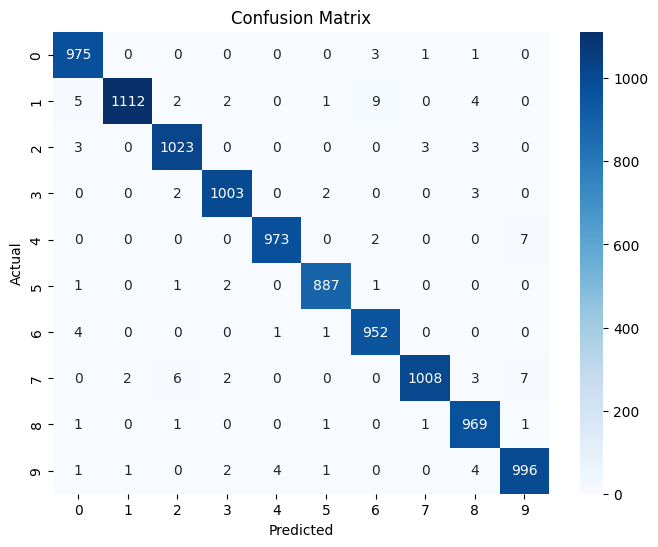

In [81]:
evaluate_cuda(model3, test_loader)

In [52]:
torch.save(model3.state_dict(), 'model/mnist_cnn.pth')

Using Leaky ReLu activation function

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model4 = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model4.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model4(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Validation step
    model4.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model4(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Epoch [1/10], Loss: 0.2465
Validation Loss: 0.0497, Accuracy: 98.61%
Epoch [2/10], Loss: 0.0757
Validation Loss: 0.0444, Accuracy: 98.82%
Epoch [3/10], Loss: 0.0570
Validation Loss: 0.0362, Accuracy: 99.02%
Epoch [4/10], Loss: 0.0439
Validation Loss: 0.0365, Accuracy: 99.08%
Epoch [5/10], Loss: 0.0394
Validation Loss: 0.0371, Accuracy: 99.13%
Epoch [6/10], Loss: 0.0313
Validation Loss: 0.0492, Accuracy: 98.74%
Epoch [7/10], Loss: 0.0267
Validation Loss: 0.0355, Accuracy: 99.26%
Epoch [8/10], Loss: 0.0278
Validation Loss: 0.0343, Accuracy: 99.21%
Epoch [9/10], Loss: 0.0221
Validation Loss: 0.0336, Accuracy: 99.27%
Epoch [10/10], Loss: 0.0230
Validation Loss: 0.0358, Accuracy: 99.19%


Accuracy: 99.38%
Precision: 0.9937, Recall: 0.9937, F1-score: 0.9937


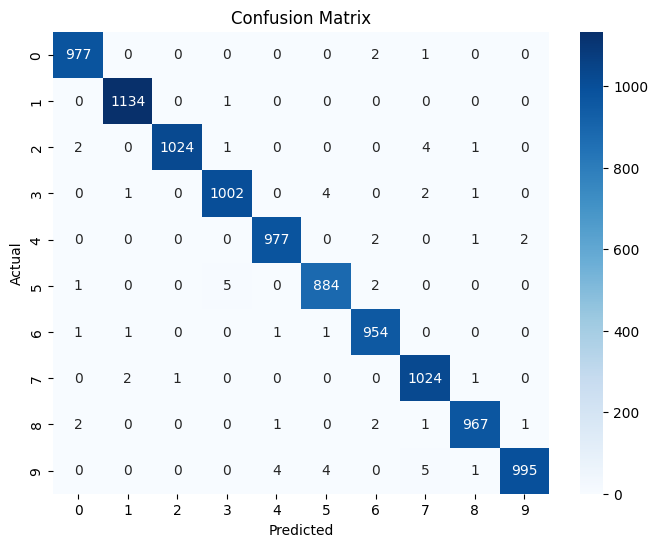

In [82]:
evaluate(model4, test_loader)